In [1]:
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'


C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 23951349.92it/s]


Extracting MNIST/MNIST\raw\train-images-idx3-ubyte.gz to MNIST/MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9261010.88it/s]


Extracting MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST/MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4530446.79it/s]

Extracting MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST/MNIST\raw



In [34]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var
    
    
        

In [35]:
def train_batch(data, model, opotimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

In [36]:
@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [37]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5* torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [38]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

EPOCH: 1.000  val_kld: 437.981  val_log_var: -0.266  train_loss: 2876.947  train_mean: 0.001  train_kld: 270.455  val_recon: 1889.907  val_loss: 2327.888  train_log_var: -0.162  val_mean: 0.003  train_recon: 2606.492  (11.38s - 102.44s remaining)


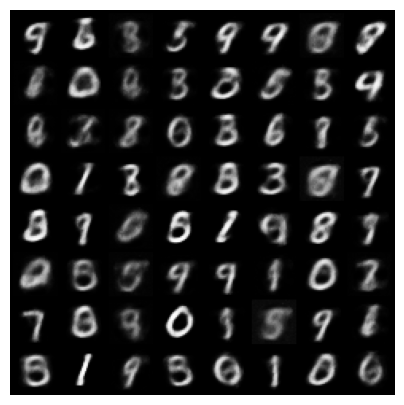

EPOCH: 2.000  val_kld: 511.515  val_log_var: -0.309  train_loss: 2191.936  train_mean: 0.002  train_kld: 492.266  val_recon: 1566.848  val_loss: 2078.364  train_log_var: -0.300  val_mean: 0.006  train_recon: 1699.670  (22.70s - 90.79s remaining)


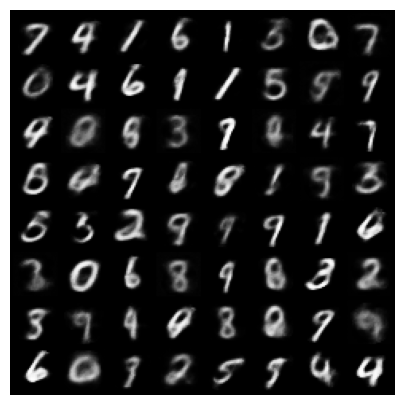

EPOCH: 3.000  val_kld: 556.572  val_log_var: -0.347  train_loss: 2055.102  train_mean: 0.001  train_kld: 545.805  val_recon: 1439.437  val_loss: 1996.009  train_log_var: -0.336  val_mean: 0.006  train_recon: 1509.297  (34.02s - 79.38s remaining)


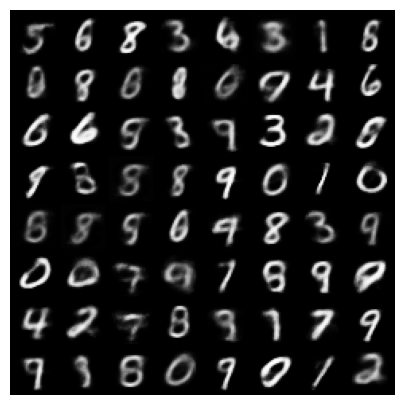

EPOCH: 4.000  val_kld: 592.644  val_log_var: -0.367  train_loss: 1986.125  train_mean: 0.001  train_kld: 573.575  val_recon: 1351.008  val_loss: 1943.651  train_log_var: -0.354  val_mean: 0.002  train_recon: 1412.550  (45.16s - 67.74s remaining)


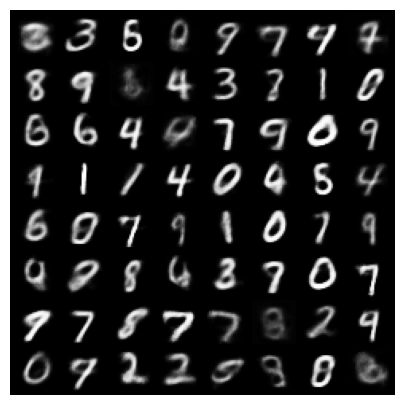

EPOCH: 5.000  val_kld: 609.012  val_log_var: -0.381  train_loss: 1948.250  train_mean: 0.001  train_kld: 589.311  val_recon: 1303.057  val_loss: 1912.069  train_log_var: -0.364  val_mean: 0.005  train_recon: 1358.939  (56.53s - 56.53s remaining)


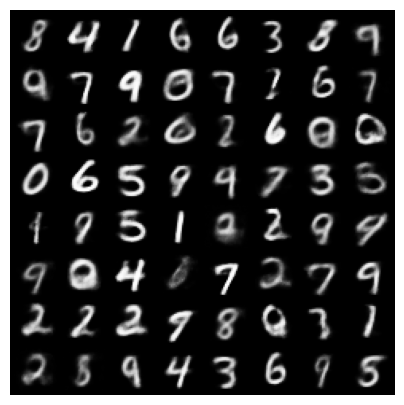

EPOCH: 6.000  val_kld: 606.450  val_log_var: -0.375  train_loss: 1917.144  train_mean: 0.001  train_kld: 599.927  val_recon: 1297.603  val_loss: 1904.052  train_log_var: -0.372  val_mean: 0.003  train_recon: 1317.217  (67.86s - 45.24s remaining)


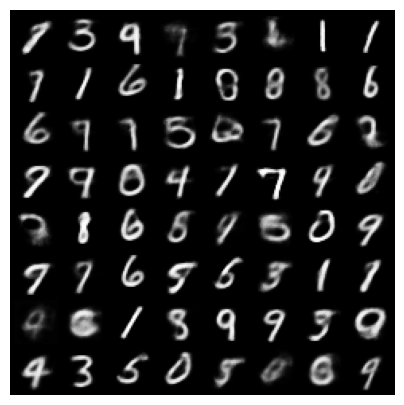

EPOCH: 7.000  val_kld: 608.002  val_log_var: -0.384  train_loss: 1893.985  train_mean: 0.001  train_kld: 610.920  val_recon: 1257.063  val_loss: 1865.065  train_log_var: -0.380  val_mean: 0.004  train_recon: 1283.065  (79.57s - 34.10s remaining)


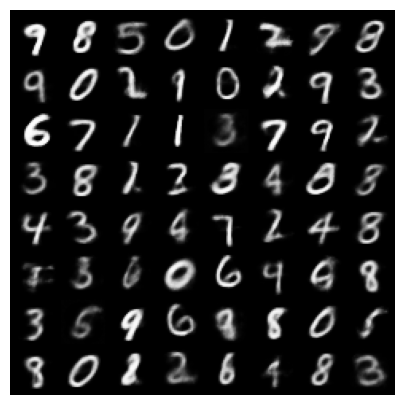

EPOCH: 8.000  val_kld: 621.297  val_log_var: -0.388  train_loss: 1877.920  train_mean: 0.001  train_kld: 618.435  val_recon: 1231.838  val_loss: 1853.135  train_log_var: -0.384  val_mean: 0.004  train_recon: 1259.485  (91.03s - 22.76s remaining)


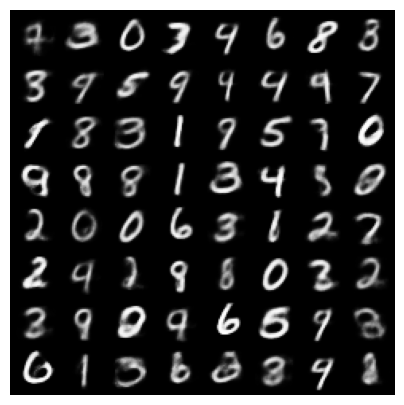

EPOCH: 9.000  val_kld: 624.902  val_log_var: -0.395  train_loss: 1862.403  train_mean: 0.001  train_kld: 624.411  val_recon: 1228.931  val_loss: 1853.833  train_log_var: -0.388  val_mean: 0.002  train_recon: 1237.992  (102.21s - 11.36s remaining)


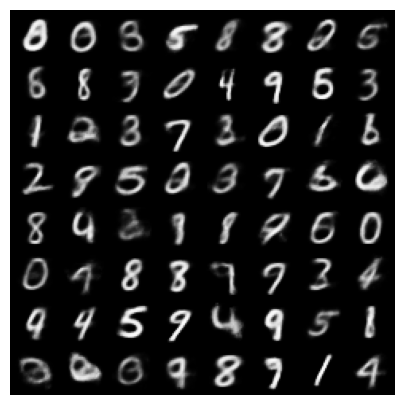

EPOCH: 10.000  val_kld: 626.511  val_log_var: -0.391  train_loss: 1848.874  train_mean: 0.001  train_kld: 629.749  val_recon: 1207.642  val_loss: 1834.153  train_log_var: -0.392  val_mean: 0.003  train_recon: 1219.125  (113.86s - 0.00s remaining)


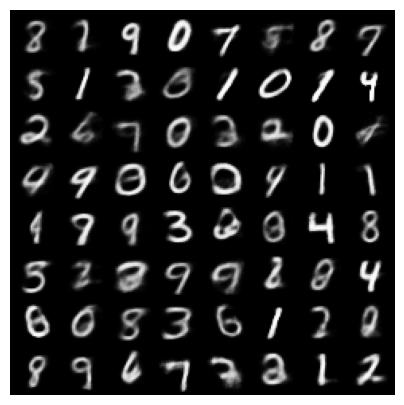

100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 542.77it/s]


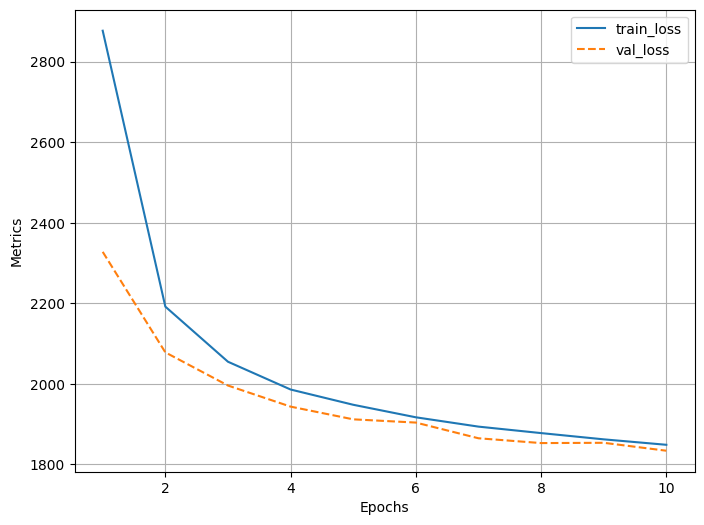

In [39]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='/r')
    
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='/r')
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)
log.plot_epochs(['train_loss','val_loss'])